# One Hot Encoding 추가

In [115]:
import pandas as pd
import holidays
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [139]:
# !pip3 install xgboost
# !pip3 uninstall lightgbm -y
# !pip3 uninstall pytimekr -y
# !pip3 install holidays

Found existing installation: pytimekr 0.1.0
Uninstalling pytimekr-0.1.0:
  Successfully uninstalled pytimekr-0.1.0


### data load

In [192]:
df1 = pd.read_csv("../dataset/international_trade.csv")
df2 = pd.read_csv("../dataset/sample_submission.csv")
df3 = pd.read_csv("../dataset/test.csv")
df4 = pd.read_csv("../dataset/train.csv")

In [182]:
df4['timestamp'] = (df4['timestamp'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Timestamp'

In [183]:
df3

,ID,timestamp,item,corporation,location
0,TG_A_J_20230304,2023-03-04,TG,A,J
1,TG_A_J_20230305,2023-03-05,TG,A,J
2,TG_A_J_20230306,2023-03-06,TG,A,J
3,TG_A_J_20230307,2023-03-07,TG,A,J
4,TG_A_J_20230308,2023-03-08,TG,A,J
...,...,...,...,...,...
1087,RD_F_J_20230327,2023-03-27,RD,F,J
1088,RD_F_J_20230328,2023-03-28,RD,F,J
1089,RD_F_J_20230329,2023-03-29,RD,F,J
1090,RD_F_J_20230330,2023-03-30,RD,F,J


## preprocessing

### analyze
- train 데이터 : 2019년 01월 01일부터 2023년 03월 03일까지의 유통된 품목의 가격 데이터
- item: 품목 코드
    - TG : 감귤
    - BC : 브로콜리
    - RD : 무
    - CR : 당근
    - CB : 양배추
- corporation : 유통 법인 코드
    - 법인 A부터 F 존재
- location : 지역 코드
    - J : 제주도 제주시
    - S : 제주도 서귀포시
- supply(kg) : 유통된 물량, kg 단위
- price(원/kg) : 유통된 품목들의 kg 마다의 가격, 원 단위

In [9]:
df1['품목명'].str.contains()

0             토마토(신선한 것이나 냉장한 것으로 한정한다)
1                                    양파
2                                    쪽파
3                  꽃양배추와 브로콜리(broccoli)
4                             방울다다기 양배추
                     ...               
1269             포포(papaw)[파파야(papaya)]
1270                                 사과
1271                                  배
1272    신 체리[프루너스 체라서스(Prunus cerasus)]
1273                                 자두
Name: 품목명, Length: 1274, dtype: object

In [4]:
df4.head()

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0


In [3]:
for i in ["item","corporation","location"]:
    print(df4[i].value_counts())
    print()

item
TG    15230
BC    13707
RD    12184
CR    10661
CB     7615
Name: count, dtype: int64

corporation
A    13707
E    13707
D    12184
C     9138
B     7615
F     3046
Name: count, dtype: int64

location
J    35029
S    24368
Name: count, dtype: int64



### try1

In [23]:
TG : 감귤
BC : 브로콜리
RD : 무
CR : 당근
CB : 양배추

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38
...,...,...,...,...,...,...,...
1269,2023-02,포포(papaw)[파파야(papaya)],0,0,23830,71,-71
1270,2023-02,사과,135165,351,0,0,351
1271,2023-02,배,2206012,5411,1,0,5411
1272,2023-02,신 체리[프루너스 체라서스(Prunus cerasus)],5,0,0,0,0


In [98]:
cond1 = df4['year'] == 2020
cond2 = df4['month'] == 2
cond3 = df4['item'] == 'TG'
df4[cond1 & cond2& cond3]["price(원/kg)"].mean()

2028.2724137931034

In [107]:
df4[["item","supply(kg)","price(원/kg)","month"]].groupby("item").mean()

,supply(kg),price(원/kg),month
item,,,
BC,1000.060071,910.196615,6.32042
CB,11241.532567,152.187131,6.32042
CR,5054.161992,273.118938,6.32042
RD,27670.840003,187.073539,6.32042
TG,14193.242484,3177.442022,6.32042


In [96]:
1_297_885.00 * 250

324471250.0

In [97]:
324471250.0 / 51859

6256.797277232496

In [99]:
df3

,ID,timestamp,item,corporation,location
0,TG_A_J_20230304,2023-03-04,TG,A,J
1,TG_A_J_20230305,2023-03-05,TG,A,J
2,TG_A_J_20230306,2023-03-06,TG,A,J
3,TG_A_J_20230307,2023-03-07,TG,A,J
4,TG_A_J_20230308,2023-03-08,TG,A,J
...,...,...,...,...,...
1087,RD_F_J_20230327,2023-03-27,RD,F,J
1088,RD_F_J_20230328,2023-03-28,RD,F,J
1089,RD_F_J_20230329,2023-03-29,RD,F,J
1090,RD_F_J_20230330,2023-03-30,RD,F,J


In [78]:
df1[df1['품목명'].str.contains("귤")]

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
17,2019-01,감귤,58368,172,0,0,172
41,2019-02,감귤,8474,33,0,0,33
64,2019-03,감귤,2061,10,4599,12,-2
88,2019-04,감귤,328,9,13457,36,-27
114,2019-05,감귤,2560,21,0,0,21
140,2019-06,감귤,3417,21,0,0,21
167,2019-07,감귤,4603,27,0,0,27
194,2019-08,감귤,5859,31,0,0,31
223,2019-09,감귤,8050,39,0,0,39
248,2019-10,감귤,3651,14,0,0,14


### 시계열로 감귤(TG)의 특정 회사(A)의 2019년 1월 한달을 그려봤다
- 가격이 0인 날이 꽤 있다. -> 살펴 봐야겠다
- 1월에 점점 가격이 올라간다

In [10]:
import matplotlib.pyplot as plt

In [21]:
cond1 = df4['item'] =='BC'
cond2 = df4['corporation'] == 'A'
cond3 = df4['month'] == 1
cond4 = df4['year'] == 2019
test = df4[cond1 & cond2 & cond3 & cond4]

/Users/goodyoung/Desktop/GIt/myMLstudy/.mlvenv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


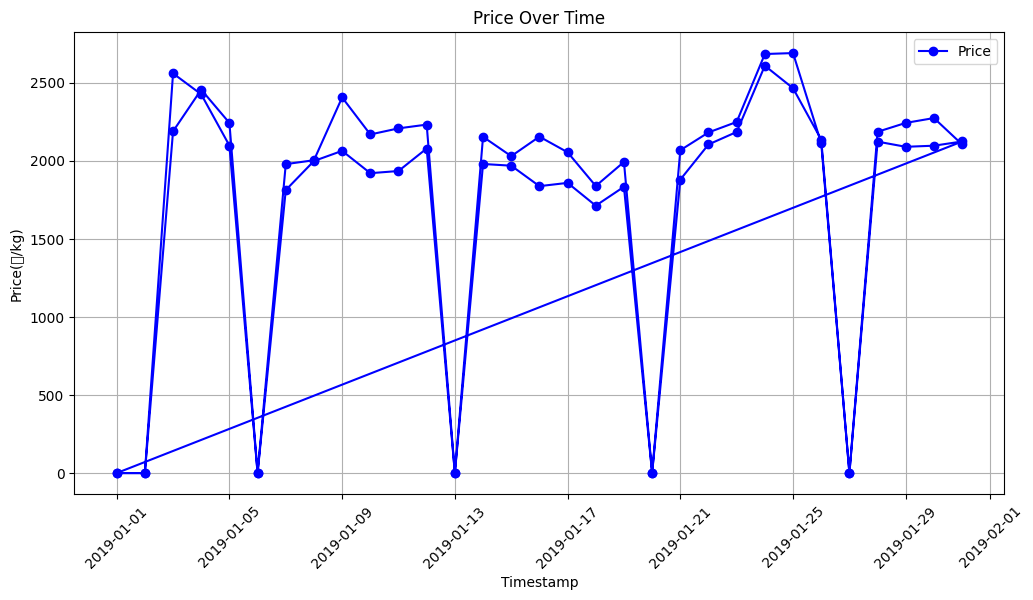

In [22]:
plt.figure(figsize=(12, 6))  # 그래프 크기 설정

plt.plot(test['timestamp'], test['price(원/kg)'],'o', linestyle='-', color='b', label='Price')  # 그래프 그리기

plt.title('Price Over Time')  # 그래프 제목 설정
plt.xlabel('Timestamp')  # x축 레이블 설정
plt.ylabel('Price(원/kg)')  # y축 레이블 설정

plt.grid(True)  # 그리드 표시
plt.legend()  # 범례 표시

plt.xticks(rotation=45)  # x축 레이블 회전

plt.show()  # 그래프 표시

### 가격이 0인 날짜들을 살펴보았다
- 휴일 (공휴일, 일요일)이면 무조건 가격이 0이다
- 평일에도 안판 법인이 있을 수 있다

In [137]:
cond1 = df['price(원/kg)'] == 0.0
# cond2 = df["timestamp"] == "2019-01-01"
df[cond1]

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day,holiday
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,0
5,TG_A_J_20190106,2019-01-06,TG,A,J,0.0,0.0,2019,1,6,0
12,TG_A_J_20190113,2019-01-13,TG,A,J,0.0,0.0,2019,1,13,0
19,TG_A_J_20190120,2019-01-20,TG,A,J,0.0,0.0,2019,1,20,0
...,...,...,...,...,...,...,...,...,...,...,...
59363,RD_F_J_20230129,2023-01-29,RD,F,J,0.0,0.0,2023,1,29,0
59370,RD_F_J_20230205,2023-02-05,RD,F,J,0.0,0.0,2023,2,5,0
59377,RD_F_J_20230212,2023-02-12,RD,F,J,0.0,0.0,2023,2,12,0
59384,RD_F_J_20230219,2023-02-19,RD,F,J,0.0,0.0,2023,2,19,0


### 수치화

In [193]:
df4 = df4.drop('ID',axis = 1)

In [194]:
def categoryChange(df):
    """ 카테고리화 """
    ordinal_encoder = OrdinalEncoder()
    ordinal = ordinal_encoder.fit_transform(df)
    return ordinal

In [195]:
for name in ['item','corporation','location']:
    df4.loc[:,name] = categoryChange(df4[[name]])
    df4[name] = pd.to_numeric(df4[name])

### 원핫인코딩

In [126]:
df4.head()

,timestamp,corporation,location,supply(kg),price(원/kg),item_BC,item_CB,item_CR,item_RD,item_TG
0,2019-01-01,0.0,0.0,0.0,0.0,False,False,False,False,True
1,2019-01-02,0.0,0.0,0.0,0.0,False,False,False,False,True
2,2019-01-03,0.0,0.0,60601.0,1728.0,False,False,False,False,True
3,2019-01-04,0.0,0.0,25000.0,1408.0,False,False,False,False,True
4,2019-01-05,0.0,0.0,32352.0,1250.0,False,False,False,False,True


In [121]:
df4 = pd.get_dummies(df4, columns=['item'])

### 날짜 분리

In [196]:
def dateChange(df):
    df.loc[:,'year'] = df['timestamp'].dt.year
    df.loc[:,'month'] = df['timestamp'].dt.month
    df.loc[:,'day'] = df['timestamp'].dt.day
    return df 

In [197]:
df4['timestamp'] = pd.to_datetime(df4['timestamp'])
df4 = dateChange(df4)

### 휴일 처리

In [198]:
import holidays
# 한국 휴일 객체 생성 
kr_holidays = holidays.KR()

df4.loc[:,'holiday'] = df4['timestamp'].apply(lambda a: 0 if a in kr_holidays else 1)
df4.loc[:,'sunday'] = df4['timestamp'].apply(lambda a: 0 if a.weekday()==6 else 1)
df4.loc[:,"holisunDay"] = pd.concat([df4["holiday"], df4["sunday"]],axis = 0,ignore_index=True)

In [199]:
df4.drop(['holiday','sunday','timestamp'],axis = 1,inplace = True)

### model training

In [201]:
X = df4.drop(['price(원/kg)','supply(kg)'],axis = 1)
Y = df4['price(원/kg)']

In [221]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42,stratify=df4['item'],shuffle=True)

In [222]:
model = RandomForestRegressor()

In [284]:
model = xgb.XGBRegressor()

In [306]:
model.fit(x_train,y_train)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [286]:
pred = model.predict(x_test)

In [287]:
"""
LinearRegressor -> 1904.0070927607574
RandomForestRegressor -> 1580.9442694709762
xgbregressor -> 1580.9064095937372

RandomForestRegressor -> 1192.357782768199 (날짜 전처리)
xgbregressor -> 1148.0481545075852 (날짜 전처리)
xgbregressor -> 1145.1369208445203 (날짜 전처리2)
xgbregressor -> 1035.0333493561188 ->(n_estimators = 300,max_depth = 7)
"""
forest_mse = mean_squared_error(y_test, pred)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

1035.0333493561188

### Submission

In [288]:
import holidays
def holisunDay(df):
    """ 한국 휴일, 일요일 피쳐 생성 """
    kr_holidays = holidays.KR()
    df.loc[:,'holiday'] = df['timestamp'].apply(lambda a: 1 if a in kr_holidays else 0)
    df.loc[:,'sunday'] = df['timestamp'].apply(lambda a: 1 if a.weekday()==6 else 0)
    df.loc[:,"holisunDay"] = pd.concat([df["holiday"], df["sunday"]],axis = 0,ignore_index=True)
    df.drop(['holiday','sunday','timestamp'],axis = 1,inplace = True)
    return df

In [289]:
def dateChange(df):
    """ 시간 분리 """  
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.loc[:,'year'] = df['timestamp'].dt.year
    df.loc[:,'month'] = df['timestamp'].dt.month
    df.loc[:,'day'] = df['timestamp'].dt.day
    return df 

In [290]:
def categoryChange(df):
    """ 카테고리화 """
    ordinal_encoder = OrdinalEncoder()
    ordinal = ordinal_encoder.fit_transform(df)
    return ordinal

In [291]:
def changeNumeric(s):
    v = pd.DataFrame(s, columns = cat_attribs+other)
    df = v[other + cat_attribs]
    for name in ['item','corporation','location']:
        df[name] = pd.to_numeric(df[name])
    return df

In [292]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

In [295]:
df = df3.copy()

In [296]:

cat_attribs = ["item",'corporation','location']
other = ['ID','timestamp']

# 수치화 파이프라인
col_pipeline = ColumnTransformer([
    ("ordinal", Pipeline([("encoder", OrdinalEncoder())]), cat_attribs),
],remainder="passthrough")

#날짜 및 휴일 피쳐 생성 파이프라인
feature_pipeline = Pipeline([
    ('dateChange', FunctionTransformer(func=dateChange, validate=False)),
    ('holisunDay', FunctionTransformer(func=holisunDay, validate=False))
])

s = col_pipeline.fit_transform(df)
df = changeNumeric(s)
# df = pd.get_dummies(df, columns=['item'])
df = feature_pipeline.transform(df)

### Modeling

In [297]:
X = df.drop(['ID'],axis = 1)

In [298]:
real = model.predict(X)

In [299]:
df2.loc[:,'answer'] = real

In [300]:
df2['answer']

0       5036.318359
1       2602.931641
2       1158.546997
3       1037.488647
4       1208.218262
           ...     
1087     -12.399359
1088     221.728043
1089     -11.092136
1090     405.934784
1091     458.434784
Name: answer, Length: 1092, dtype: float32

In [301]:
df2.to_csv("answer.csv",index = False)